# Matrix Factorization with Expander Graphs

## Supporting Functions

### Functions for generating and checking data

In [1]:
# IMPORTS
import numpy as np
import copy
import matplotlib.pyplot as plt
from timeit import default_timer as timer


# DATA GENERATION AND PERFORMANCE CHECKING FUNCTIONS
def generate_latent(n,k,c1,c2):
    b = c2-c1
    a = c1/b
    x = np.zeros(n)
    locs = np.random.permutation(n)[:k]
    x[locs] = 1
    signs = np.sign(np.random.randn(k))
    vals = b*(np.random.rand(k)+a)
    x[locs] = x[locs]*vals*signs
    return x

def generate_exp_dictionary1(m,n,d):
    A = np.zeros((m,n))
    for i in range(n):
        locs = np.random.permutation(m)[:d]
        A[locs,i] = 1
    return A

def generate_exp_dictionary2(m,n,d):
    A = np.zeros((m,n))
    alpha = int(np.floor(m/d))
    c = 0
    while c<n:
        perm = np.random.permutation(m)
        zeta = min(n-c, alpha)
        for j in range(zeta):
            locs = perm[j*d:(j+1)*d]
            A[locs,c] = 1
            c = c+1
    return A

def check_dictionary(eps,n,d,A):
    t = (1-4*eps)*d
    mu_A = np.max(np.transpose(A)@A - d*np.identity(n))
    if mu_A >= t:
        print("Generation error, A is not expander for this value of epsilon, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = False
    else:
        print("A passes coherence test, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = True
    return passed  
        
def check_recon_A(A,A_rec,d,eps,n):
    print("Checking reconstruction of A.")
    col_sum = sum(A_rec)
    print(str.format('{0:.1f}',100*len(col_sum[col_sum==d])/n), "% of columns fully formed.")
    print(str.format('{0:.1f}',100*(n - len(col_sum[col_sum==d]) - len(col_sum[col_sum==0]))/n) , "% of columns partially formed.")
    print(str.format('{0:.1f}', 100*len(col_sum[col_sum==0])/n), "% of columns have no entries.")
    overlaps = np.transpose(A_rec)@A
    A_rec_col, A_col = np.where(overlaps>(1-4*eps)*d)
    if len(col_sum[col_sum==0])<n:
        print(str.format('{0:.1f}', 100*len(A_rec_col)/(n - len(col_sum[col_sum==0]))), "% of reconstructed (fully or partially) columns match with a column in target matrix.")  
    error = 0
    missing = 0
    P = np.zeros((n,n))
    for i in range(len(A_rec_col)):
        diff = A_rec[:, A_rec_col[i]] - A[:,A_col[i]]
        error = error + sum(abs(diff[diff==1]))
        missing = missing + sum(abs(diff[diff==-1]))
        P[A_col[i], A_rec_col[i]] = 1
    print(str.format('{0:.0f}', 100*(missing+d*n-len(A_rec_col)*d)/(d*n)), "% of entries missing in total.")
    print(str.format('{0:.0f}', missing), "entries missing in matched columns.")
    print(str.format('{0:.0f}', error), "entries wrong in matched columns.")
    return P
    
def check_recon_X(X,X_rec,P,N,k,n):
    X_perm = P@X_rec
    print("Checking the values of X recovered.")
    tol = 10**-6
    total_entries = N*k
    total_entries_recovered = 0
    correct_loc_correct_val = 0
    correct_loc_wrong_val = 0
    wrong_loc = 0
    missing = 0
    passed = True
    for i in range(N):
        for j in range(n):
            if abs(X[j,i])>tol and abs(X_perm[j,i])>tol:
                error = abs(X[j,i] - X_perm[j,i])
                if error < tol:
                    correct_loc_correct_val +=1
                else:
                    correct_loc_wrong_val += 1
                    print("Column number = ", i, ", row number = ", j, ", true value = ", X[j,i], "value found = ", X_perm[j,i])
            elif abs(X[j,i])>tol and abs(X_perm[j,i])<tol:
                missing += 1
            elif abs(X[j,i])<tol and abs(X_perm[j,i])>tol:
                wrong_loc += 1
    print(str.format('{0:.1f}', 100*(correct_loc_correct_val/total_entries)), "% of entries correctly recovered.")
    print(str.format('{0:.1f}', 100*(correct_loc_wrong_val/total_entries)), "% of entries in correct location but have wrong value for location.")
    print(str.format('{0:.1f}', 100*(missing/total_entries)), "% of entries missing.")
    return X_perm
    

### Auxillary functions

In [2]:
# USED IN BOTH EXPERIMENTS 1 and 2
def xps2(y,x_vals,x_locs,A_rec,m,eps,d,k):
    tol1 = 10**-8
    tol2 = 10**-8
    y_copy = copy.deepcopy(y)
    t = (1-2*eps)*d
    z1 = len(y_copy);
    W = np.zeros((m,k))
    vals = np.zeros(k)
    q = 0
    for i in range(z1):
        if np.abs(y_copy[i])> tol1:
            locs = list()
            locs.append(i)
            for j in range(i+1, m):
                if np.abs(y_copy[j] - y_copy[i]) < tol2:
                    locs.append(j)
                    y_copy[j] = 0
            match = np.where(y_copy[i]==x_vals)[0]
            if not match:
                if len(locs)>t:
                    W[locs,q] = 1
                    vals[q] = y_copy[i]
                    q = q+1
            elif len(match)==1:
                A_rec[locs, x_locs[match[0]]] = 1
            else:
                print('ERROR - column value matches with more than 1 singleton value already extracted')
        y_copy[i] = 0
    W = W[:,:q]
    vals = vals[:q]
    return [W, A_rec, vals, q]

def process_column2(y, A_rec, x, m, eps, d, k, c, dpid):
    exit_flag = True
    tau = (1-4*eps)*d
    x_locs = np.nonzero(x)[0]
    x_vals = np.zeros(len(x_locs))
    for i in range(len(x_locs)):
        x_vals[i] = x[x_locs[i]]  
    [W, A_rec, vals, q] = xps2(y,x_vals,x_locs,A_rec,m,eps,d,k)
    if q > 0:
        match_check = np.zeros(q) 
        match_col_id = -0.5*np.ones(q)
        data_id = dpid*np.ones(q)          
        if c > 0:           
            matches = np.transpose(W)@A_rec
            matches[matches<=tau] = 0
            matches[matches>tau] = 1
            num_matches = matches.sum(axis=1)
            col_ind = matches@np.arange(c)           
            for i in range(q):
                if num_matches[i] == 0:
                    if c>=n:
                        print("Error: trying to add new column which exceeds total number of columns")
                        exit_flag==False
                elif num_matches[i] == 1:
                    match_check[i] = 1                   
                    z = int(col_ind[i])
                    match_col_id[i] = z
                elif num_matches[i] > 1:
                    print("Error: partial support matches with ", num_matches[i]," partially reconstructed columns of A.")
                    exit_flag = False
    else:
        exit_flag = False
        match_check = []
        match_col_id = []
        data_id = []
    return [W, A_rec, match_check, match_col_id, data_id, vals, exit_flag]

def sort_unmatched_columns(W, eps, d, c): 
    q = W.shape[1]
    col_id_new = -0.5*np.zeros(q)
    tau = (1-4*eps)*d
    matches = np.transpose(W)@W
    matches[matches<=tau] = 0
    matches[matches>tau] = 1
    i =0
    while i<q:
        if sum(matches[:,i]) > 0:
            temp = np.where(matches[:,i]==1)[0]
            col_id_new[temp] = c
            c +=1
            for j in range(len(temp)):
                matches[temp[j],:] = np.zeros(q)
                matches[:,temp[j]] = np.zeros(q)
        i +=1
    return [col_id_new, c]

def update_reconstruction(W, col_id, data_id, vals, A_rec, X_rec):
    for i in range(len(col_id)):
        A_rec[:, int(col_id[i])] += W[:,i]
        X_rec[int(col_id[i]), int(data_id[i])] = vals[i]
    A_rec[A_rec>0] = 1
    return [A_rec, X_rec]


def l0_decode(r, x, A, num_comp, alpha):
    vals = np.unique(r)
    vals = vals[vals!=0]
    r_0 = np.count_nonzero(r)
    for j in range(num_comp):
        for v in np.nditer(vals):
            u = r - v*A[:,j]
            if r_0 - np.count_nonzero(u) >= alpha:
                x[j] = x[j] + v
    return x

In [3]:
# A = np.random.rand(4,5)
# print(A)
# x = np.array([1,2,4,1.5,0])
# x_rec = np.zeros(5)
# y = A@x
# print(y)
# x_rec = l0_decode(y, x_rec, A, 5, 2)
# print(A.shape)

### EBR Algorithm

In [4]:
def EBR(Y,N,m,n,d,k,eps,max_epochs,A_sparsity,X_sparsity,Y_frob):
    epoch = 0
    c = 0
    tol = 10**-8 # make sure is smaller than 1
    exit_program=False  
    A_rec = np.zeros((m,n))
    X_rec = np.zeros((n,N))
    frob_error_series = np.ones(max_epoch)
    A_entries = np.zeros(max_epoch)
    X_entries = np.zeros(max_epoch)
    total_entries = np.zeros(max_epoch)
    R = copy.deepcopy(Y)    
    start_time = timer()
    while epoch < max_epoch and frob_error_series[epoch] > tol and exit_program==False:            
        num_matched = 0
        num_new = 0    
        for i in range(N):
            [W, A_rec[:,:c], match_check, match_col_id, data_id, vals, supports_found]=process_column2(R[:,i], A_rec[:,:c], X_rec[:,i], m, eps, d, k, c, i)
            matches = np.where(match_check==1)[0]
            new = np.where(match_check==0)[0]
            if supports_found == True:
                if len(matches)>0:
                    if num_matched > 0:
                        W_match = np.concatenate((W_match, W[:,matches]), axis=1)
                        col_id_match = np.concatenate((col_id_match, match_col_id[matches]), axis=0)
                        data_id_match = np.concatenate((data_id_match, data_id[matches]), axis=0)
                        val_match = np.concatenate((val_match, vals[matches]), axis=0)
                    else:
                        W_match = W[:,matches]
                        col_id_match = match_col_id[matches]
                        data_id_match = data_id[matches]
                        val_match = vals[matches]
                        num_matched += W_match.shape[1]

                if len(new)>0:
                    if num_new > 0:
                        W_new = np.concatenate((W_new, W[:,new]), axis=1)
                        data_id_new = np.concatenate((data_id_new, data_id[new]), axis=0)
                        val_new = np.concatenate((val_new, vals[new]), axis=0)
                    else:
                        W_new = W[:,new]
                        data_id_new = data_id[new]
                        val_new = vals[new]
                        num_new += W_new.shape[1]

        if num_matched > 0 and num_new > 0:
            [col_id_new, c] = sort_unmatched_columns(W_new, eps, d, c)       
            W_all = np.concatenate((W_match, W_new), axis=1)
            col_id_all = np.concatenate((col_id_match, col_id_new), axis=0)
            data_id_all = np.concatenate((data_id_match, data_id_new), axis=0)
            val_all = np.concatenate((val_match, val_new), axis=0)          
        elif num_matched > 0 and num_new == 0:
            W_all = W_match
            col_id_all = col_id_match
            data_id_all = data_id_match
            val_all = val_match     
        elif num_matched == 0 and num_new > 0:
            [col_id_all, c] = sort_unmatched_columns(W_new, eps, d, c)
            W_all = W_new
            data_id_all = data_id_new
            val_all = val_new                       
        elif num_matched == 0 and num_new == 0:
            print("No partial supports recovered, terminating algorithm")
            frob_error_series[epoch:] = frob_error_series[epoch-1]
            A_entries[epoch:] = A_entries[epoch-1]
            X_entries[epoch:] = X_entries[epoch-1]
            total_entries[epoch:] = total_entries[epoch-1]
            exit_program = True
        if exit_program == False:
            [A_rec, X_rec] = update_reconstruction(W_all, col_id_all, data_id_all, val_all, A_rec, X_rec)
            R = Y - A_rec@X_rec
            R[R<tol] = 0
            frob_error_series[epoch] = np.sqrt(sum(sum(R**2)))
            A_entries[epoch] = np.count_nonzero(A_rec)
            X_entries[epoch] = np.count_nonzero(X_rec)
            total_entries[epoch] = A_entries[epoch] + X_entries[epoch]    
            print('Epoch ', str.format('{0:.0f}', epoch), " processed, l_2 error = ", str.format('{0:.2f}', 100*frob_error_series[epoch]/Y_frob), '%, A l_0 error =', str.format('{0:.2f}', 100*(A_sparsity - A_entries[epoch])/A_sparsity), '%, X l_0 error =', str.format('{0:.2f}', 100*(X_sparsity - X_entries[epoch])/X_sparsity), '%.')
            if epoch == max_epoch:
                print("Maximum number of epochs reached.")
            epoch +=1
    
    end_time = timer()
    comp_time = end_time - start_time
    return [A_rec, X_rec, frob_error_series, total_entries, A_entries, X_entries, comp_time]

In [5]:
def EBR_l0(Y,N,m,n,d,k,eps,max_epochs,A_sparsity,X_sparsity,Y_frob, alpha):
    epoch = 0
    c = 0
    tol = 10**-5 # make sure is smaller than 1
    exit_program=False  
    A_rec = np.zeros((m,n))
    X_rec = np.zeros((n,N))
    frob_error_series = np.ones(max_epoch)
    A_entries = np.zeros(max_epoch)
    X_entries = np.zeros(max_epoch)
    total_entries = np.zeros(max_epoch)
    R = copy.deepcopy(Y)    
    start_time = timer()
    while epoch < max_epoch and frob_error_series[epoch] > tol and exit_program==False:            
        num_matched = 0
        num_new = 0    
        for i in range(N):
            [W, A_rec[:,:c], match_check, match_col_id, data_id, vals, supports_found]=process_column2(R[:,i], A_rec[:,:c], X_rec[:,i], m, eps, d, k, c, i)
            matches = np.where(match_check==1)[0]
            new = np.where(match_check==0)[0]
            if supports_found == True:
                if len(matches)>0:
                    if num_matched > 0:
                        W_match = np.concatenate((W_match, W[:,matches]), axis=1)
                        col_id_match = np.concatenate((col_id_match, match_col_id[matches]), axis=0)
                        data_id_match = np.concatenate((data_id_match, data_id[matches]), axis=0)
                        val_match = np.concatenate((val_match, vals[matches]), axis=0)
                    else:
                        W_match = W[:,matches]
                        col_id_match = match_col_id[matches]
                        data_id_match = data_id[matches]
                        val_match = vals[matches]
                        num_matched += W_match.shape[1]

                if len(new)>0:
                    if num_new > 0:
                        W_new = np.concatenate((W_new, W[:,new]), axis=1)
                        data_id_new = np.concatenate((data_id_new, data_id[new]), axis=0)
                        val_new = np.concatenate((val_new, vals[new]), axis=0)
                    else:
                        W_new = W[:,new]
                        data_id_new = data_id[new]
                        val_new = vals[new]
                        num_new += W_new.shape[1]

        if num_matched > 0 and num_new > 0:
            [col_id_new, c] = sort_unmatched_columns(W_new, eps, d, c)       
            W_all = np.concatenate((W_match, W_new), axis=1)
            col_id_all = np.concatenate((col_id_match, col_id_new), axis=0)
            data_id_all = np.concatenate((data_id_match, data_id_new), axis=0)
            val_all = np.concatenate((val_match, val_new), axis=0)          
        elif num_matched > 0 and num_new == 0:
            W_all = W_match
            col_id_all = col_id_match
            data_id_all = data_id_match
            val_all = val_match     
        elif num_matched == 0 and num_new > 0:
            [col_id_all, c] = sort_unmatched_columns(W_new, eps, d, c)
            W_all = W_new
            data_id_all = data_id_new
            val_all = val_new                       
        elif num_matched == 0 and num_new == 0:
            print("No partial supports recovered, terminating algorithm")
            frob_error_series[epoch:] = frob_error_series[epoch-1]
            A_entries[epoch:] = A_entries[epoch-1]
            X_entries[epoch:] = X_entries[epoch-1]
            total_entries[epoch:] = total_entries[epoch-1]
            exit_program = True    
        
        if exit_program == False:
            [A_rec, X_rec] = update_reconstruction(W_all, col_id_all, data_id_all, val_all, A_rec, X_rec)
            R = Y - A_rec@X_rec
            R[R<tol] = 0         
            ### RUN l-0 HERE using competed columns ####
            col_sumA = np.sum(A_rec, axis = 0)
            col_sumA[col_sumA != d] = 0
            comp = np.nonzero(col_sumA)[0]
            num_comp = len(comp)
            
            col_sumR = np.sum(R**2, axis = 0)
            col_sumR[col_sumR < tol] = 0
            not_dec = np.nonzero(col_sumR)[0]
            for j in np.nditer(not_dec):
                X_rec[comp,j] = l0_decode(R[:,j], X_rec[comp, j], A_rec[:,comp], num_comp, alpha)
            ############################################
            R = Y - A_rec@X_rec
            R[R<tol] = 0            
            frob_error_series[epoch] = np.sqrt(sum(sum(R**2)))
            A_entries[epoch] = np.count_nonzero(A_rec)
            X_entries[epoch] = np.count_nonzero(X_rec)
            total_entries[epoch] = A_entries[epoch] + X_entries[epoch]    
            print('Epoch ', str.format('{0:.0f}', epoch), " processed, l_2 error = ", str.format('{0:.2f}', 100*frob_error_series[epoch]/Y_frob), '%, A l_0 error =', str.format('{0:.2f}', 100*(A_sparsity - A_entries[epoch])/A_sparsity), '%, X l_0 error =', str.format('{0:.2f}', 100*(X_sparsity - X_entries[epoch])/X_sparsity), '%.')
            if epoch == max_epoch:
                print("Maximum number of epochs reached.")
            epoch +=1
    
    end_time = timer()
    comp_time = end_time - start_time
    return [A_rec, X_rec, frob_error_series, total_entries, A_entries, X_entries, comp_time]

# Experiments supporting Lemma 6 and Remark 1

In [6]:
max_iter = 2000
num_trials = 400
n = np.arange(200, 1050, 50)
alpha = [0.1, 0.2, 0.6]

theoretical_average = np.zeros((len(alpha)+1, len(n)))

theoretical_average[0] = n*np.log(n)
for i in range(len(alpha)):
    theoretical_average[i+1] = (1/alpha[i])*np.log(n)
    
exp_av = np.zeros((len(alpha), len(n)))

# Iterate through each problem size n    
for i in range(len(n)):
    # Iterate through each value of k
    for j in range(len(alpha)):
        k = int(np.around(alpha[j]*n[i]))
        # Iterate through the number of trials we conduct for problem, i.e. fixed k and n
        for l in range(num_trials):
            # A single trial is concluded when all objects have been seen
            seen = np.zeros(n[i])
            iters = 0
            done = False
            while done == False and iters <= max_iter:
                draw = np.random.choice(n[i], k, replace=False)
                for r in range(k):
                    seen[draw[r]] = 1         
                if sum(seen) == n[i]:
                    done = True
                    exp_av[j, i] += iters
                else:
                    iters +=1
exp_av = exp_av/num_trials
    

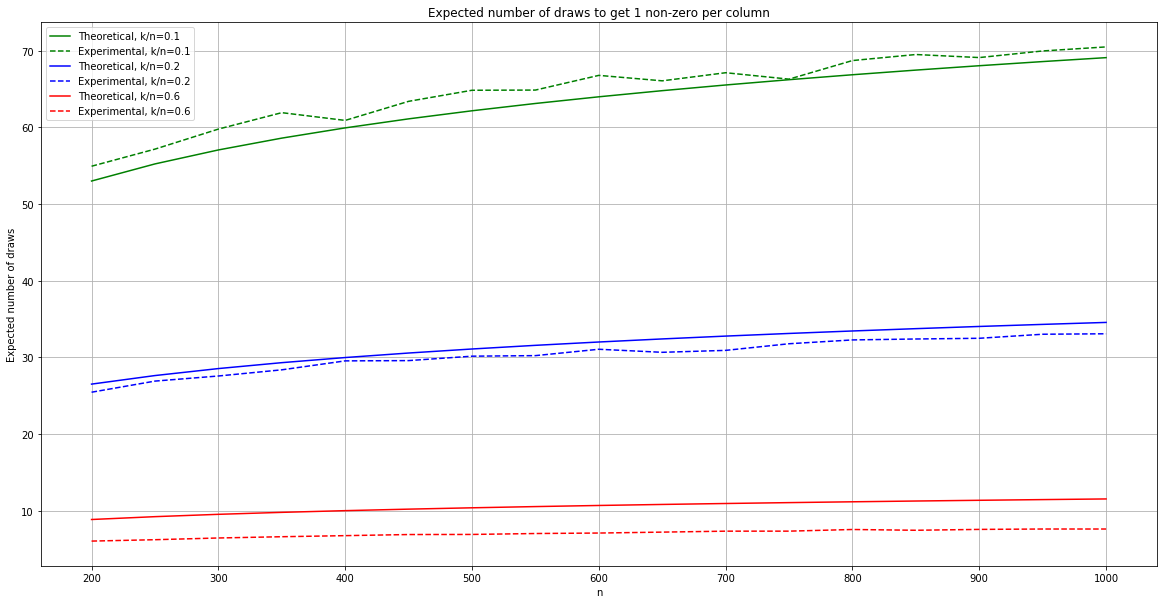

In [7]:
plt.figure(1)
plt.figure(figsize=(20,10))
# plt.plot(n, theoretical_average[0], 'k-', label="k=1")
plt.plot(n, theoretical_average[1], 'g-', label="Theoretical, k/n=%s"%(alpha[0]))
plt.plot(n, exp_av[0], 'g--', label="Experimental, k/n=%s"%(alpha[0]))
plt.plot(n, theoretical_average[2], 'b-', label="Theoretical, k/n=%s"%(alpha[1]))
plt.plot(n, exp_av[1], 'b--', label="Experimental, k/n=%s"%(alpha[1]))
plt.plot(n, theoretical_average[3], 'r-', label="Theoretical, k/n=%s"%(alpha[2]))
plt.plot(n, exp_av[2], 'r--', label="Experimental, k/n=%s"%(alpha[2]))
plt.grid(True)
plt.title('Expected number of draws to get 1 non-zero per column')
plt.xlabel('n')
plt.ylabel('Expected number of draws')
plt.legend()
plt.savefig('./figures_ACHA/sample_comp.eps', format='eps', bbox_inches='tight')

# Experiments analyzing performance of EBR

## Experiment 1 - recovery varying $k/n$

#### Generating a valid dictionary and data

802
Generation error, A is not expander for this value of epsilon, mu_A =  4.00 , tau =  3.33 .
A passes coherence test, mu_A =  3.00 , tau =  3.33 .
Generated dictionary that passes the coherency test
(1313, 1500)
15000.0
10.0
12.0
11.424219345
11.424219345011425


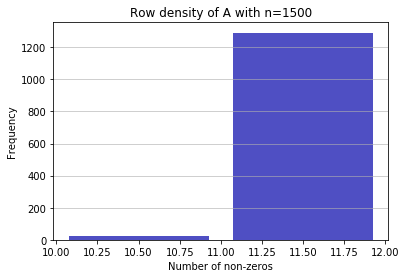

In [21]:
# Dictionary parameters parameters
n = 1500; #800
beta = 7/8
ceta = 15

m = int(np.ceil(n*beta));
d = 10; # 9
eps = 1/6;
N = int(np.around(ceta*(np.log(n))**2))
print(N)

# Generate a dictionary and check that passes necessary test.
num_generations = 0
passed = False
while passed==False and num_generations < 100:
    A = generate_exp_dictionary2(m,n,d);
    passed = check_dictionary(eps,n,d,A)
    num_generations += 1
if passed == True:
    print("Generated dictionary that passes the coherency test")
else:
    print("Failed to generate dictionary that passes the coherency test, consider different parameters")
    
# Analyze characteristics of dictionary
row_count = np.sum(A, 1)
print(A.shape)
print(sum(sum(A)))
print(min(row_count))
print(max(row_count))
print(np.mean(row_count))
print(n*d/m)

num_bins = int(max(row_count) - min(row_count))
freq, bins, patches = plt.hist(row_count, bins=num_bins, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of non-zeros')
plt.ylabel('Frequency')
plt.title('Row density of A with n=%s'%(n))
maxfreq = freq.max()

#### Generate data using dictionary

In [25]:
##### GENERATE LATENT REPRESENTATION
b1=1;
b2=5;
k = [int(np.ceil(0.04*n)), int(np.ceil(0.07*n)), int(np.ceil(0.1*n))]
X = np.zeros((len(k), n, N))
Y = np.zeros((len(k), m, N))
for j in range(len(k)):
    for i in range(N):
        X[j,:,i] = generate_latent(n,k[j],b1,b2)
    Y[j] = A@X[j]

#### Run EBR to recover A and X varying $k/n$

In [26]:
if passed == True:
    eps = 1/6;
    max_epoch = 10
    tol = 10**-8
    X_sparsity = np.zeros(len(k))
    Y_frob = np.zeros(len(k))
    comp_time = np.zeros(len(k))
    number_k_to_process = len(k)
    A_sparsity = np.count_nonzero(A)
    A_rec = np.zeros((len(k),m,n))
    X_rec = np.zeros((len(k),n,N))
    frob_error_series = np.ones((len(k), max_epoch))
    A_entries = np.zeros((len(k), max_epoch))
    X_entries = np.zeros((len(k), max_epoch))
    total_entries = np.zeros((len(k), max_epoch))
    for j in range(number_k_to_process):
        print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k[j]/n), '%, N = ', str.format('{0:.0f}', N))
        X_sparsity[j] = k[j]*N
        Y_frob[j] = np.sqrt(sum(sum(Y[j]**2)))
        [A_rec[j], X_rec[j], frob_error_series[j], total_entries[j], A_entries[j], X_entries[j], comp_time[j]] = EBR(Y[j],N,m,n,d,k[j],eps,max_epoch,A_sparsity,X_sparsity[j],Y_frob[j])
        print("")
        P = check_recon_A(A, A_rec[j],d,eps,n)
        print("")
        check_recon_X(X[j],X_rec[j],P,N,k[j],n)
        print("")

Solving problem with k/n =  4.0 %, N =  802
Epoch  0  processed, l_2 error =  48.56 %, A l_0 error = 0.00 %, X l_0 error = 46.98 %.
Epoch  1  processed, l_2 error =  29.67 %, A l_0 error = 0.00 %, X l_0 error = 33.11 %.
Epoch  2  processed, l_2 error =  21.33 %, A l_0 error = 0.00 %, X l_0 error = 28.75 %.
Epoch  3  processed, l_2 error =  17.82 %, A l_0 error = 0.00 %, X l_0 error = 27.29 %.
Epoch  4  processed, l_2 error =  16.41 %, A l_0 error = 0.00 %, X l_0 error = 26.75 %.
Epoch  5  processed, l_2 error =  15.82 %, A l_0 error = 0.00 %, X l_0 error = 26.57 %.
Epoch  6  processed, l_2 error =  15.65 %, A l_0 error = 0.00 %, X l_0 error = 26.51 %.
Epoch  7  processed, l_2 error =  15.62 %, A l_0 error = 0.00 %, X l_0 error = 26.49 %.
Epoch  8  processed, l_2 error =  15.61 %, A l_0 error = 0.00 %, X l_0 error = 26.49 %.
No partial supports recovered, terminating algorithm

Checking reconstruction of A.
100.0 % of columns fully formed.
0.0 % of columns partially formed.
0.0 % of col

Running times:
k/n=4.0 %, 497.840935768 s
k/n=7.066666666666666 %, 963.813716384 s
k/n=10.0 %, 1007.24212838 s


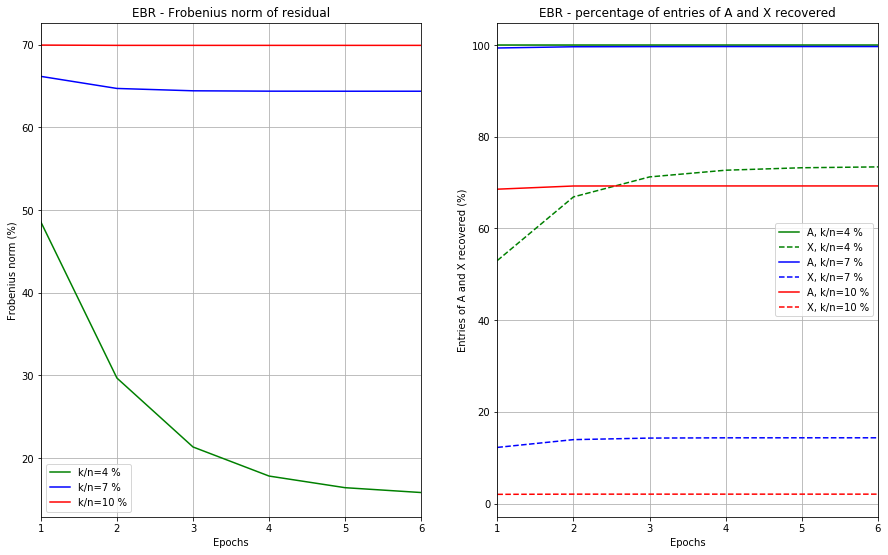

In [45]:
plt.figure(1).clear()

plot_A_entries = 100*A_entries/A_sparsity

plot_X_entries = np.zeros((len(k), max_epoch))
plot_frob = np.zeros((len(k), max_epoch))

for j in range(number_k_to_process):
    plot_frob[j,:] = 100*frob_error_series[j,:]/np.sqrt(sum(sum(Y[j]**2)))
    plot_X_entries[j,:] = 100*X_entries[j,:]/X_sparsity[j]
plot_epoch = 6

print("Running times:")
print("k/n=%s %%, %s s"%(100*k[0]/n, comp_time[0]))
print("k/n=%s %%, %s s"%(100*k[1]/n, comp_time[1]))      
print("k/n=%s %%, %s s"%(100*k[2]/n, comp_time[2]))  

plt.figure(1)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_frob[0], 'g-', label="k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_frob[1], 'b-', label="k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_frob[2], 'r-', label="k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.title('EBR - Frobenius norm of residual')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Frobenius norm (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_A_entries[0], 'g-', label="A, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[0], 'g--',label="X, k/n=%s %%"%(int(round(100*k[0]/n, 1))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[1], 'b-', label="A, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[1], 'b--',label="X, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[2], 'r-', label="A, k/n=%s %%"%(int(round(100*k[2]/n, 1))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[2], 'r--',label="X, k/n=%s %%"%(int(round(100*k[2]/n, 1))))
plt.grid(True)
plt.title('EBR - percentage of entries of A and X recovered')
plt.xlabel('Epochs')
plt.ylabel('Entries of A and X recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.savefig('./figures_ACHA/varying_k_EBR.eps', format='eps', bbox_inches='tight')

In [46]:
if passed == True:
    alpha = 3
    eps = 1/6;
    max_epoch = 10
    tol = 10**-8
    X_sparsity = np.zeros(len(k))
    Y_frob = np.zeros(len(k))
    comp_time = np.zeros(len(k))
    number_k_to_process = len(k)
    A_sparsity = np.count_nonzero(A)
    A_rec = np.zeros((len(k),m,n))
    X_rec = np.zeros((len(k),n,N))
    frob_error_series = np.ones((len(k), max_epoch))
    A_entries = np.zeros((len(k), max_epoch))
    X_entries = np.zeros((len(k), max_epoch))
    total_entries = np.zeros((len(k), max_epoch))
    for j in range(number_k_to_process):
        print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k[j]/n), '%, N = ', str.format('{0:.0f}', N))
        X_sparsity[j] = k[j]*N
        Y_frob[j] = np.sqrt(sum(sum(Y[j]**2)))
        [A_rec[j], X_rec[j], frob_error_series[j], total_entries[j], A_entries[j], X_entries[j], comp_time[j]] = EBR_l0(Y[j],N,m,n,d,k[j],eps,max_epoch,A_sparsity,X_sparsity[j],Y_frob[j],alpha)
        print("")
        P = check_recon_A(A, A_rec[j],d,eps,n)
        print("")
        check_recon_X(X[j],X_rec[j],P,N,k[j],n)
        print("")

Solving problem with k/n =  4.0 %, N =  802
Epoch  0  processed, l_2 error =  6.14 %, A l_0 error = 0.00 %, X l_0 error = 24.47 %.
Epoch  1  processed, l_2 error =  4.22 %, A l_0 error = 0.00 %, X l_0 error = 23.99 %.
Epoch  2  processed, l_2 error =  4.20 %, A l_0 error = 0.00 %, X l_0 error = 23.98 %.
No partial supports recovered, terminating algorithm

Checking reconstruction of A.
100.0 % of columns fully formed.
0.0 % of columns partially formed.
0.0 % of columns have no entries.
100.0 % of reconstructed (fully or partially) columns match with a column in target matrix.
0 % of entries missing in total.
0 entries missing in matched columns.
0 entries wrong in matched columns.

Checking the values of X recovered.
Column number =  15 , row number =  947 , true value =  2.03972497762 value found =  4.07944995525
Column number =  18 , row number =  1080 , true value =  4.59300837444 value found =  13.567384304
Column number =  57 , row number =  507 , true value =  4.91542210476 value

Running times:
k/n=4.0 %, 734.214130046 s
k/n=7.066666666666666 %, 3186.93549437 s
k/n=10.0 %, 6456.78333846 s


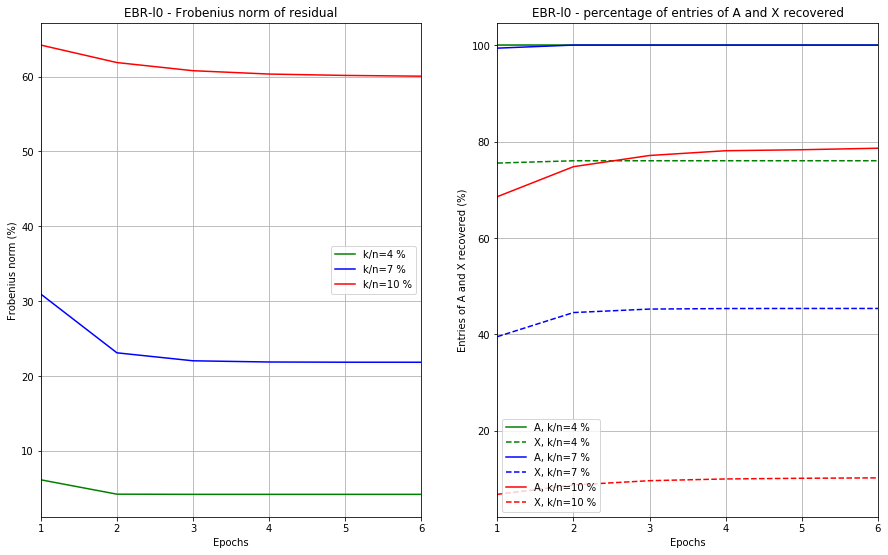

In [47]:
plt.figure(2).clear()

plot_A_entries = 100*A_entries/A_sparsity

plot_X_entries = np.zeros((len(k), max_epoch))
plot_frob = np.zeros((len(k), max_epoch))

for j in range(number_k_to_process):
    plot_frob[j,:] = 100*frob_error_series[j,:]/np.sqrt(sum(sum(Y[j]**2)))
    plot_X_entries[j,:] = 100*X_entries[j,:]/X_sparsity[j]
plot_epoch = 6

print("Running times:")
print("k/n=%s %%, %s s"%(100*k[0]/n, comp_time[0]))
print("k/n=%s %%, %s s"%(100*k[1]/n, comp_time[1]))      
print("k/n=%s %%, %s s"%(100*k[2]/n, comp_time[2]))  

plt.figure(2)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_frob[0], 'g-', label="k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_frob[1], 'b-', label="k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_frob[2], 'r-', label="k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.title('EBR-l0 - Frobenius norm of residual')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Frobenius norm (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_A_entries[0], 'g-', label="A, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[0], 'g--',label="X, k/n=%s %%"%(int(round(100*k[0]/n, 1))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[1], 'b-', label="A, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[1], 'b--',label="X, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[2], 'r-', label="A, k/n=%s %%"%(int(round(100*k[2]/n, 1))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[2], 'r--',label="X, k/n=%s %%"%(int(round(100*k[2]/n, 1))))
plt.grid(True)
plt.title('EBR-l0 - percentage of entries of A and X recovered')
plt.xlabel('Epochs')
plt.ylabel('Entries of A and X recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.savefig('./figures_ACHA/varying_k_EBR.eps', format='eps', bbox_inches='tight')

# Experiment 2 - recovery varying n, m and k, keeping n/k, d and N fixed

In [ ]:
# PARAMETERS
gamma =0.04
beta = 5/6
ceta = 15

# Test 1
n1 = 600;
m1 = int(np.ceil(beta*n1))
k1 = int(np.ceil(gamma*n1)) 
# Test 2
n2 = 1000;
m2 = int(np.ceil(beta*n2))
k2 = int(np.ceil(gamma*n2))
# Test 2
n3 = 1400;
m3 = int(np.ceil(beta*n3))
k3 = int(np.ceil(gamma*n3)) 

# Shared
b1=1
b2=5
d = 7
N2 = int(np.around(ceta*(np.log(n1))**2))
eps = 1/6;

In [ ]:
# Generate dictionary and data for test 1
num_generations = 0
passed1 = False
while passed1==False and num_generations < 100:
    A1 = generate_exp_dictionary2(m1,n1,d);
    passed1 = check_dictionary(eps,n1,d,A1)
    num_generations += 1
if passed1 == True:
    print("Generated dictionary that passes the coherency test")
else:
    print("Failed to generate dictionary that passes the coherency test, consider different parameters")

X1 = np.zeros((n1, N2))
Y1 = np.zeros((m1, N2))

for i in range(N2):
    X1[:,i] = generate_latent(n1,k1,b1,b2)
Y1 = A1@X1

In [ ]:
## Generate dictionary and data for test 2
num_generations = 0
passed2 = False
while passed2==False and num_generations < 100:
    A2 = generate_exp_dictionary2(m2,n2,d);
    passed2 = check_dictionary(eps,n2,d,A2)
    num_generations += 1
if passed2 == True:
    print("Generated dictionary that passes the coherency test")
else:
    print("Failed to generate dictionary that passes the coherency test, consider different parameters")

X2 = np.zeros((n2, N2))
Y2 = np.zeros((m2, N2))

for i in range(N2):
    X2[:,i] = generate_latent(n2,k2,b1,b2)
Y2= A2@X2

In [ ]:
## Generate dictionary and data for test 3
num_generations = 0
passed3 = False
while passed3==False and num_generations < 100:
    A3 = generate_exp_dictionary2(m3,n3,d);
    passed3 = check_dictionary(eps,n3,d,A3)
    num_generations += 1
if passed3 == True:
    print("Generated dictionary that passes the coherency test")
else:
    print("Failed to generate dictionary that passes the coherency test, consider different parameters")

X3 = np.zeros((n3, N2))
Y3 = np.zeros((m3, N2))

for i in range(N2):
    X3[:,i] = generate_latent(n3,k3,b1,b2)
Y3= A3@X3

In [ ]:
if passed1 == True:
    max_epoch = 10
    tol = 10**-8
    X_sparsity1 = 0
    Y_frob1 = 0
    comp_time1 = 0
    A_sparsity1 = np.count_nonzero(A1)
    A_rec1 = np.zeros((m1,n1))
    X_rec1 = np.zeros((n1,N2))
    frob_error_series1 = np.ones(max_epoch)
    A_entries1 = np.zeros( max_epoch)
    X_entries1 = np.zeros(max_epoch)
    total_entries1 = np.zeros(max_epoch)

    print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k1/n1),'%, n = ', str.format('{0:.0f}', n1), ', N = ', str.format('{0:.0f}', N2))
    X_sparsity1 = k1*N2
    Y_frob1 = np.sqrt(sum(sum(Y1**2)))
    [A_rec1, X_rec1, frob_error_series1, total_entries1, A_entries1, X_entries1, comp_time1] = EBR(Y1,N2,m1,n1,d,k1,eps,max_epoch,A_sparsity1,X_sparsity1,Y_frob1)
    print("")
    P1 = check_recon_A(A1,A_rec1,d,eps,n1)
    print("")
    check_recon_X(X1,X_rec1,P1,N2,k1,n1)
    print("")

In [ ]:
if passed2 == True:
    max_epoch = 10
    tol = 10**-8
    X_sparsity2 = 0
    Y_frob2 = 0
    comp_time2 = 0
    A_sparsity2 = np.count_nonzero(A2)
    A_rec2 = np.zeros((m2,n2))
    X_rec2 = np.zeros((n2,N2))
    frob_error_series2= np.ones(max_epoch)
    A_entries2 = np.zeros( max_epoch)
    X_entries2 = np.zeros(max_epoch)
    total_entries2 = np.zeros(max_epoch)

    print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k2/n2),'%, n = ', str.format('{0:.0f}', n2), ', N = ', str.format('{0:.0f}', N2))
    X_sparsity2 = k2*N2
    Y_frob2 = np.sqrt(sum(sum(Y2**2)))
    [A_rec2, X_rec2, frob_error_series2, total_entries2, A_entries2, X_entries2, comp_time2] = EBR(Y2,N2,m2,n2,d,k2,eps,max_epoch,A_sparsity2,X_sparsity2,Y_frob2)
    print("")
    P2 = check_recon_A(A2,A_rec2,d,eps,n2)
    print("")
    check_recon_X(X2,X_rec2,P2,N2,k2, n2)
    print("")

In [ ]:
if passed3 == True:
    max_epoch = 10
    tol = 10**-8
    X_sparsity3 = 0
    Y_frob3 = 0
    comp_time3 = 0
    A_sparsity3 = np.count_nonzero(A3)
    A_rec3 = np.zeros((m3,n3))
    X_rec3 = np.zeros((n3,N2))
    frob_error_series3= np.ones(max_epoch)
    A_entries3 = np.zeros(max_epoch)
    X_entries3 = np.zeros(max_epoch)
    total_entries3 = np.zeros(max_epoch)

    print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k3/n3),'%, n = ', str.format('{0:.0f}', n3), ', N = ', str.format('{0:.0f}', N2))
    X_sparsity3 = k3*N2
    Y_frob3 = np.sqrt(sum(sum(Y3**2)))
    [A_rec3, X_rec3, frob_error_series3, total_entries3, A_entries3, X_entries3, comp_time3] = EBR(Y3,N2,m3,n3,d,k3,eps,max_epoch,A_sparsity3,X_sparsity3,Y_frob3)
    print("")
    P3 = check_recon_A(A3,A_rec3,d,eps,n3)
    print("")
    check_recon_X(X3,X_rec3,P3,N2,k3, n3)
    print("")

In [ ]:
plt.figure(2).clear()

plot_A_entries1 = 100*A_entries1/A_sparsity1
plot_X_entries1 = 100*X_entries1/X_sparsity1
plot_frob1 = 100*frob_error_series1/np.sqrt(sum(sum(Y1**2)))

plot_A_entries2 = 100*A_entries2/A_sparsity2
plot_X_entries2 = 100*X_entries2/X_sparsity2
plot_frob2 = 100*frob_error_series2/np.sqrt(sum(sum(Y2**2)))

plot_A_entries3 = 100*A_entries3/A_sparsity3
plot_X_entries3 = 100*X_entries3/X_sparsity3
plot_frob3 = 100*frob_error_series3/np.sqrt(sum(sum(Y3**2)))

plot_epoch = 6

print("Running times:")
print("n1=%s %%, %s s"%(n1, comp_time1))
print("n2=%s %%, %s s"%(n2, comp_time2))
print("n3=%s %%, %s s"%(n3, comp_time3))
    
plt.figure(2)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_frob1, 'g-', label="n=%s"%(n1))
plt.plot(np.arange(max_epoch)+1, plot_frob2, 'b-', label="n=%s"%(n2))
plt.plot(np.arange(max_epoch)+1, plot_frob3, 'r-', label="n=%s"%(n3))
plt.title('Frobenius error percentage of Y-AX')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Frobenius error percentage of Y-AX (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_A_entries1, 'g-', label="A, n=%s"%(n1))
plt.plot(np.arange(max_epoch)+1, plot_X_entries1, 'g--',label="X, n=%s"%(n1))
plt.plot(np.arange(max_epoch)+1, plot_A_entries2, 'b-', label="A, n=%s"%(n2))
plt.plot(np.arange(max_epoch)+1, plot_X_entries2, 'b--',label="X, n=%s"%(n2))
plt.plot(np.arange(max_epoch)+1, plot_A_entries3, 'r-', label="A, n=%s"%(n3))
plt.plot(np.arange(max_epoch)+1, plot_X_entries3, 'r--',label="X, n=%s"%(n3))
plt.grid(True)
plt.title('Percentage of entries of A and X Recovered with N = %s'%(N2))
plt.xlabel('Epochs')
plt.ylabel('Percentage of entries of A and X recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.savefig('./figures_ACHA/varying_N.eps', format='eps', bbox_inches='tight')

# Experiment 3 - post processing improvement in recovering $X$

In [ ]:
# PARAMETERS
gamma =0.03
beta = 5/6
ceta = 15

# Test 1
n4 = 1000;
m4 = int(np.ceil(beta*n4))
k4 = int(np.ceil(gamma*n4)) 
d4 = 7

# Shared
b1=1
b2=5

N4 = int(np.around(ceta*(np.log(n4))**2))
eps = 1/6;

In [ ]:
#### Generate dictionary for experiment 3
num_generations = 0
passed4 = False
while passed4==False and num_generations < 100:
    A4 = generate_exp_dictionary2(m4,n4,d4);
    passed4 = check_dictionary(eps,n4,d,A4)
    num_generations += 1
if passed4 == True:
    print("Generated dictionary that passes the coherency test")
else:
    print("Failed to generate dictionary that passes the coherency test, consider different parameters")

X4 = np.zeros((n4, N4))
Y4 = np.zeros((m4, N4))

for i in range(N4):
    X4[:,i] = generate_latent(n4,k4,b1,b2)
Y4 = A4@X4

In [ ]:
# Run standard EBR
if passed1 == True:
    max_epoch = 10
    tol = 10**-8
    X_sparsity4 = N4*k4
    Y_frob4 = 0
    comp_time4 = 0
    A_sparsity4 = np.count_nonzero(A4)
    A_rec4 = np.zeros((m4,n4))
    X_rec4 = np.zeros((n4,N4))
    frob_error_series4 = np.ones(max_epoch)
    A_entries4 = np.zeros( max_epoch)
    X_entries4 = np.zeros(max_epoch)
    total_entries4 = np.zeros(max_epoch)

    print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k4/n4),'%, n = ', str.format('{0:.0f}', n4), ', N = ', str.format('{0:.0f}', N4))
    Y_frob4 = np.sqrt(sum(sum(Y4**2)))
    [A_rec4, X_rec4, frob_error_series4, total_entries4, A_entries4, X_entries4, comp_time4] = EBR(Y4,N4,m4,n4,d4,k4,eps,max_epoch,A_sparsity4,X_sparsity4,Y_frob4)
    print("")
    P4 = check_recon_A(A4,A_rec4,d4,eps,n4)
    print("")
    check_recon_X(X4,X_rec4,P4,N4,k4,n4)
    print("")
    

In [ ]:
# Run EBR interweaved with l-0 decode
if passed1 == True:
    max_epoch = 10
    alpha = 3
    tol = 10**-8
    Y_frob4 = 0
    comp_time5 = 0
    A_rec5 = np.zeros((m4,n4))
    X_rec5 = np.zeros((n4,N4))
    frob_error_series5 = np.ones(max_epoch)
    A_entries5 = np.zeros(max_epoch)
    X_entries5 = np.zeros(max_epoch)
    total_entries5 = np.zeros(max_epoch)

    print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k4/n4),'%, n = ', str.format('{0:.0f}', n4), ', N = ', str.format('{0:.0f}', N4))
    Y_frob4 = np.sqrt(sum(sum(Y4**2)))
    [A_rec5, X_rec5, frob_error_series5, total_entries5, A_entries5, X_entries5, comp_time5] = EBR_l0(Y4,N4,m4,n4,d4,k4,eps,max_epoch,A_sparsity4,X_sparsity4,Y_frob4, alpha)
    print("")
    P5 = check_recon_A(A4,A_rec5,d4,eps,n4)
    print("")
    check_recon_X(X4,X_rec5,P5,N4,k4,n4)
    print("")

In [ ]:
plt.figure(4).clear()

plot_A_entries4 = 100*A_entries4/A_sparsity4
plot_X_entries4 = 100*X_entries4/X_sparsity4
plot_frob4 = 100*frob_error_series4/np.sqrt(sum(sum(Y4**2)))

plot_A_entries5 = 100*A_entries5/A_sparsity4
plot_X_entries5 = 100*X_entries5/X_sparsity4
plot_frob5 = 100*frob_error_series5/np.sqrt(sum(sum(Y4**2)))

plot_epoch = 6

print("Running times:")
print("n=%s %%, %s s"%(n4, comp_time4))

plt.figure(4)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_frob4, 'g-', label="EBR")
plt.plot(np.arange(max_epoch)+1, plot_frob5, 'b-', label="EBR & l0")
plt.title('Frobenius Error of Reconstruction')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Frobenius error percentage of Y-AX (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_A_entries4, 'k-', label="A, EBR")
plt.plot(np.arange(max_epoch)+1, plot_A_entries5, 'k-', label="A, EBR & l0")
plt.plot(np.arange(max_epoch)+1, plot_X_entries4, 'g--',label="X, EBR")
plt.plot(np.arange(max_epoch)+1, plot_X_entries5, 'b--',label="X, EBR & l0")
plt.grid(True)
plt.title('Percentage of entries of A and X Recovered')
plt.xlabel('Epochs')
plt.ylabel('Percentage of entries of A and X recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.savefig('./figures_ACHA/varying_N.eps', format='eps', bbox_inches='tight')